# Getting the 3D coordinates from 2D smoothed coordinates (`_processed_3d_kinematics.npy`)

### Icare's help functions for getting the proper depth

In [17]:
CAMERA_WIDTH = 640
CAMERA_HEIGHT = 480

get_joint_name_UP2 = {
    0: "nose",
    1: "left elbow",
    2: "right elbow",
    3: "left wrist",
    4: "right wrist",
    5: "left thumb",
    6: "right thumb",
    7: "left shoulder",
    8: "right shoulder",
}

def setup_pre_filters():
    selected = PRE_PROCESS['selected']
    filters_list = []

    if selected == None:
        return filters_list

    for filt_name in selected:
        filter_object = eval('rs.'+filt_name+'()')
        options = PRE_PROCESS[filt_name].keys()
        for option in options:
            eval('filter_object.set_option(rs.option.'+option+', '+str(PRE_PROCESS[filt_name][option])+')')
        filters_list.append(filter_object)

    return filters_list


def getValidDepth(center_x,center_y,depth_map,R_max = 10, prev_val = 0):
    
    calc_depth = 0
    for R_s in range(0, R_max):
        for y in range(-R_s,R_s):
            y_r = min(max(center_y + y,0), CAMERA_HEIGHT-1)
            for x in range(-R_s,R_s):
                x_r = min(max(center_x + x,0), CAMERA_WIDTH-1)
                calc_depth = depth_map.get_distance(x_r,y_r)

                if calc_depth > 0.5 and calc_depth < 5:
                    return calc_depth

    return prev_val

### Visualization of RGB, Depth, and depth at the shoulders
#### It works specifically with that one video that we used (the shoulder line is set up manually for that video)
#### This code presents the correct way of reading the depth values:

In [28]:
import sys
sys.path.append('/repo/data_synchronization')
import ffmpegio
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
import argparse
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def sample_depth_across_line(depth_frame, intrinsics, x1, y1, x2, y2, right_shoulder_pixel_space, left_shoulder_pixel_space, num_samples=100):
    """
    Samples depth measurements across a line in the scene and visualizes the depth.
    
    Parameters:
    depth_frame: rs.frame
        The depth frame from the RealSense camera.
    intrinsics: rs.intrinsics
        The camera intrinsics for depth deprojection.
    x1, y1, x2, y2: int
        Coordinates defining the line across which to sample depth.
    num_samples: int, optional
        Number of samples to take along the line. Default is 100.
    
    Returns:
    None
    """
    
    # Generate coordinates along the line
    x_coords = np.linspace(x1, x2, num_samples)
    y_coords = np.linspace(y1, y2, num_samples)

    # Extract depth values along the line
    depth_values = []
    for x, y in zip(x_coords, y_coords):
        depth = depth_frame.get_distance(int(x), int(y))
        if depth > 0:  # Ignore invalid depth values
            depth_values.append(depth)
        else:
            depth_values.append(np.nan)

    # Deproject pixel to point (3D coordinates)
    points = [rs.rs2_deproject_pixel_to_point(intrinsics, [x, y], depth)
              for x, y, depth in zip(x_coords, y_coords, depth_values)]

    deprojected_right_shoulder = rs.rs2_deproject_pixel_to_point(intrinsics, right_shoulder_pixel_space[:2], depth_frame.get_distance(int(right_shoulder_pixel_space[0]), int(right_shoulder_pixel_space[1])))
    deprojected_left_shoulder = rs.rs2_deproject_pixel_to_point(intrinsics, left_shoulder_pixel_space[:2], depth_frame.get_distance(int(left_shoulder_pixel_space[0]), int(left_shoulder_pixel_space[1])))
    
    points = np.array(points)


    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(points[:, 0], points[:, 2], c='b', label='Depth')
    # draw vertical line at point right_shoulder
    ax.axvline(deprojected_right_shoulder[0], color='r', linestyle='--', label='Right Shoulder')
    # draw vertical line at point left_shoulder
    ax.axvline(deprojected_left_shoulder[0], color='g', linestyle='--', label='Left Shoulder')
    ax.set_xlabel('Sample Point')
    ax.set_ylabel('Depth (meters)')
    ax.set_title('Depth Profile Across Line')
    # limit y axis
    ax.set_ylim(2.25, 2.75)
    ax.set_xlim(-0.2, 1.5)
    ax.legend()
    ax.grid(True)

    # Convert plot to numpy array
    canvas = FigureCanvas(fig)
    canvas.draw()
    plot_image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    plot_image = plot_image.reshape(canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)
    return plot_image

def create_videos_from_bag(path_bag, output_folder, points_2d, bounding_box):
    """
    Extracts a vector representing face movement over time from a realsense .bag file.

    This function processes a the .bag file specified by `path_bag` to detect and track
    a bellow nose to forehead vector using a Mediapipe face model.

    Parameters:
    - path_bag (str): Path to the .bag file containing the realsense data.
    - mediapipe_face_model_file (str): Path to the Mediapipe face model file for face detection.

    Returns:
    - numpy.ndarray: An array of shape (frames, 3)
      Each row contains the x, y, z vector direction relative to another facial point.

    Notes:
    - The function assumes a video resolution of 640x480.
    - RealSense SDK is used for video processing, and playback is adjusted to process frames
      as needed, avoiding real-time constraints.
    - Frames where the face is not detected are handled by repeating the last valid detection.
    - The function visualizes face landmarks and their movements in real-time during processing.
    - Press 'q' to quit the visualization and processing early.
    - The function smooths the movement data for visualization purposes.

    Raises:
    - Exception: If there are issues initializing the video pipeline or processing frames.
    """

    points_2d[:, :, 0] = points_2d[:, :, 0] + bounding_box[0]
    points_2d[:, :, 1] = points_2d[:, :, 1] + bounding_box[1]

    print("Processing: ", path_bag)
    
    # try:

    pipeline = rs.pipeline()
    config = rs.config()
    rs.config.enable_device_from_file(config, path_bag)

    config.enable_stream(rs.stream.depth, CAMERA_WIDTH, CAMERA_HEIGHT, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, CAMERA_WIDTH, CAMERA_HEIGHT, rs.format.bgr8, 30)

    profile = pipeline.start(config)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_stream_profile = profile.get_stream(rs.stream.depth)

    intr = depth_stream_profile.as_video_stream_profile().get_intrinsics() # Intrisic camera parameters

    playback = profile.get_device().as_playback()
    playback.set_real_time(True)
    duration = playback.get_duration().total_seconds() * 1000
    print(f"Overall video duration: {playback.get_duration()}")
    depth_scale = depth_sensor.get_depth_scale()
    align_to = rs.stream.color
    alignedFs = rs.align(align_to)

    depth_filters = setup_pre_filters()

    # except Exception as e:
    #     return 0, str(e), 0
    
    # we want to set_real_time to False, so that we can process the frames as slowly as necessary.
    # However, there are errors reading it at the beginning and at the end (hopefully not in the middle)
    # when we set it to False right at the beginning. Therefore, we set it to True at the beginning 
    # and then to False after the first frame is read. The end is handled differently - with reading the frames
    # up to the duration of the video - 1s (to be sure that we don't miss the last frame)

    first_frame = True
    prev_ts = -1
    max_frame_nb = 0
    frame_nb = -1

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1) 
    ts = 0
    time_series = []
    video_counter = 0
    failed = False
    problematic_frames = 0
    # playback.seek(datetime.timedelta(seconds=73*4))

    points_3d = []

    # try:
    while True:
        try:
            frames = pipeline.wait_for_frames()
        except Exception as e:
            print("READING ERROR")
            duration = prev_ts # use previous timestamp as the current one can be corrupt
            print(f"Duration after reading error: {duration // (1000*60)}:{(duration // 1000) % 60}:{(duration % 1000) // 10}")
            failed = str(e)
            break

        aligned_frames = alignedFs.process(frames)
        depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()
        color_image_1 = np.asanyarray(color_frame.get_data())

        playback.set_real_time(False)

        # skipped frame by RealSense
        if not depth_frame or not color_frame:
            problematic_frames += 1
            if len(points_3d) > 0:
                points_3d.append(points_3d[-1])
            else:
                # the detection will not work, which is ok, we filter it with quality
                # frames_list.append(np.zeros((480, 640, 3), dtype=np.uint8))
                points_3d.append(np.zeros((len(points_2d[0]), 5)))
            continue

        frame_nb = color_frame.get_frame_number()

        # finish of the file (no more new frames)
        if frame_nb < max_frame_nb:
            break

        max_frame_nb = frame_nb

        ts = frames.get_timestamp()

        for filter in depth_filters:
            depth_frame =  filter.process(depth_frame)
        
        depth_frame = rs.depth_frame(depth_frame)

        x1, y1, x2, y2 = 300, 110, 500, 110
        depth_cut = sample_depth_across_line(depth_frame, intr, x1, y1, x2, y2, points_2d[frame_nb, 8, :], points_2d[frame_nb, 7, :])

        ###################################### VISUALIZATION
        depth_image = np.asanyarray(depth_frame.get_data())
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image_1.shape

        for i, point in enumerate(points_2d[frame_nb]):
            x, y = point[0], point[1]
            # if x or y is nan, skip this point
            if np.isnan(x) or np.isnan(y):
                continue
            cv2.circle(color_image_1, (int(x), int(y)), 5, (0, 255, 0), -1)
            cv2.putText(color_image_1, get_joint_name_UP2.get(i, ''), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            cv2.circle(depth_colormap, (int(x), int(y)), 5, (0, 255, 0), -1)
            cv2.putText(depth_colormap, get_joint_name_UP2.get(i, ''), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # draw the line x1, y1, x2, y2 on color and depth images
        cv2.line(color_image_1, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.line(depth_colormap, (x1, y1), (x2, y2), (0, 255, 0), 2)

        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image_1, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap))
        else:
            images = np.hstack((color_image_1, depth_colormap))

        if depth_cut.shape != depth_colormap_dim:
            depth_cut = cv2.resize(depth_cut, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((images, depth_cut))

        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)
        cv2.waitKey(1)
        ########################################## END OF VISUALIZATION

        if first_frame: 
            t0 = ts
            first_frame = False
        
        # the video is at the end (without the last second) so we kill the reading
        # (there was an error with the last frame, this handles it)
        if ts - t0 + 1000 > duration:
            break

        if prev_ts > int(ts-t0):
            problematic_frames += 1
            continue

        if prev_ts == int(ts-t0):
            problematic_frames += 1
            continue

        # go over points_2d in a frame and get the 3D coordinates
        current_frame_3d_points = []
        for joint_number, point in enumerate(points_2d[frame_nb]):
            x = point[0]
            y = point[1]
            mediapipe_depth = point[2]
            quality = point[3]

            previous_value = 0 if len(points_3d) == 0 else points_3d[-1][joint_number][2]
            # skip point if x or y is np.nan
            if np.isnan(x) or np.isnan(y):
                current_frame_3d_points.append([np.nan, np.nan, np.nan, np.nan, np.nan])
                continue


            new_x, new_y, new_depth = rs.rs2_deproject_pixel_to_point(
                    intr, # intrinsics
                    [x, y], # x and y of a point
                    getValidDepth(int(x), int(y), depth_frame, 5, previous_value)) 

            current_frame_3d_points.append([new_x, new_y, new_depth, mediapipe_depth, quality])
        
        points_3d.append(np.array(current_frame_3d_points))

        time_series.append(ts)
        
        prev_prev_ts = prev_ts
        prev_ts = int(ts-t0)

        if prev_ts - prev_prev_ts > 2*int(1000/30) - 10:
            num_of_skipped_frames = (prev_ts - prev_prev_ts) // int(1000/30)
            problematic_frames += num_of_skipped_frames

            if len(points_3d) > 0:
                for i in range(num_of_skipped_frames):
                    points_3d.append(points_3d[-1])
            else:
                for i in range(num_of_skipped_frames):
                    points_3d.append(np.zeros((len(points_2d[0]), 5)))

        ch = cv2.waitKey(1)
        if ch==113: #q pressed
            failed = "Keyboard Interrupt"
            break
        t = ts - t0

    # except Exception as e:
    #     failed = str(e)
    #     duration = prev_ts

    # finally:
    if len(points_3d) > 0:
        points_3d = np.stack(points_3d)
        non_zero_index = np.where((points_3d != np.zeros((len(points_2d[0]), 5))).any(axis=1))[0][0]
        points_3d[:non_zero_index] = points_3d[non_zero_index]
        np.save(os.path.join(output_folder, '3d_points.npy'), np.array(points_3d))

    pipeline.stop()
    cv2.destroyAllWindows()
    
    return prev_ts / 1000, failed, problematic_frames

### Run the code here:

In [ ]:


# Me Experimenting:
PRE_PROCESS = {
    'selected': ['spatial_filter', 'temporal_filter', 'hole_filling_filter'],
    # 'selected': ['temporal_filter'],
    # 'decimation_filter': {'filter_magnitude': 1.0},
    'spatial_filter': {'filter_magnitude': 5.0, 'filter_smooth_alpha': 0.6, 'filter_smooth_delta': 8},
    'hole_filling_filter': {'holes_fill': 2},
    'temporal_filter': {'filter_smooth_alpha': 1, 'filter_smooth_delta': 8}
}

create_videos_from_bag('/media/mpicek/T7/martin/bags/cam0_911222060374_record_06_09_2023_1440_06.bag',
                       '/media/mpicek/T7/martin/bags/',
                       np.load('/media/mpicek/T7/martin/bags/cam0_911222060374_record_06_09_2023_1440_06_processed_kinematics.npy'),
                       np.load('/media/mpicek/T7/martin/bags/cam0_911222060374_record_06_09_2023_1440_06_bounding_box.npy'))

## Plotting the joints in 3D (but better visualization is the cell after this one)
### Creates 3d_joints_animation.mp4 in this folder!

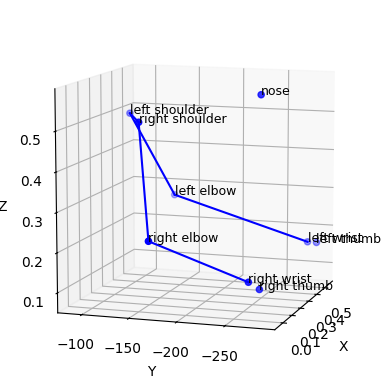

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

get_joint_name_UP2 = {
    0: "nose",
    1: "left elbow",
    2: "right elbow",
    3: "left wrist",
    4: "right wrist",
    5: "left thumb",
    6: "right thumb",
    7: "left shoulder",
    8: "right shoulder",
}

def plot_3d_joints_animation_with_labels(joints_sequence, save_path='3d_joints_animation.mp4'):
    """
    Creates a rotating 3D plot of joints with labels and saves it as a video.
    
    Parameters
    ----------
    joints_sequence : np.ndarray
        A numpy array of shape (num_frames, num_joints, 3) where each row represents a frame of joints' (x, y, z) coordinates.
    save_path : str
        The path where the video will be saved.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    def update(frame):
        ax.clear()
        x = joints_sequence[frame*5, :, 0]
        z = -joints_sequence[frame*5, :, 1]
        y = joints_sequence[frame*5, :, 3]

        ax.scatter(x, y, z, c='b', marker='o')

        for i, name in get_joint_name_UP2.items():
            ax.text(x[i], y[i], z[i], name, fontsize=9)

        # Draw lines between shoulders, elbows, and wrists to visualize the skeleton
        ax.plot([x[1], x[3]], [y[1], y[3]], [z[1], z[3]], c='b')
        ax.plot([x[2], x[4]], [y[2], y[4]], [z[2], z[4]], c='b')
        ax.plot([x[1], x[7]], [y[1], y[7]], [z[1], z[7]], c='b')
        ax.plot([x[2], x[8]], [y[2], y[8]], [z[2], z[8]], c='b')
        ax.plot([x[7], x[8]], [y[7], y[8]], [z[7], z[8]], c='b')
        
        # line between shoulders
        # ax.plot([x[7], x[8]], [y[7], y[8]], [z[7], z[8]], c='b')
        # # line between right shoulder and right wrist
        # ax.plot([x[8], x[4]], [y[8], y[4]], [z[8], z[4]], c='b')
        # # line between left shoulder and left wrist
        # ax.plot([x[7], x[5]], [y[7], y[5]], [z[7], z[5]], c='b')

    

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # Set axis to have equal scale
        ax.set_box_aspect([1, 1, 1])
        # set ranges of the plot
        # ax.set_xlim(-2, -1)
        # ax.set_ylim(-300, -100)
        # ax.set_zlim(0, 1)
        ax.view_init(elev=10., azim=frame * 2)

    num_frames = joints_sequence.shape[0]
    ani = animation.FuncAnimation(fig, update, frames=100, interval=50)

    ani.save(save_path, writer='ffmpeg')

##########################################################################
# CREATES A VIDEO IN THIS DIRECTORY (3d_joints_animation.mp4)
##########################################################################
points_3d = np.load('/media/mpicek/T7/martin/bags/3d_points.npy')
plot_3d_joints_animation_with_labels(points_3d)

## This is the best visualization: Shows where the points are read from the image + the 3D visualization next to it

/tmp/ipykernel_95793/1349228644.py:91: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


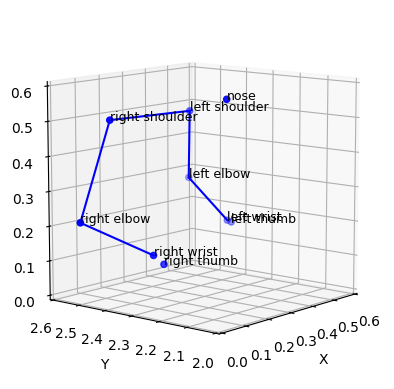

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import cv2

get_joint_name_UP2 = {
    0: "nose",
    1: "left elbow",
    2: "right elbow",
    3: "left wrist",
    4: "right wrist",
    5: "left thumb",
    6: "right thumb",
    7: "left shoulder",
    8: "right shoulder",
}

def plot_3d_joints_animation_with_labels(joints_sequence, points_2d, bounding_box, patient_path, save_path='combined_animation.mp4'):
    """
    Creates a rotating 3D plot of joints with labels and saves it as a video alongside the original video with 2D joint points overlaid.
    
    Parameters
    ----------
    joints_sequence : np.ndarray
        A numpy array of shape (num_frames, num_joints, 3) where each row represents a frame of joints' (x, y, z) coordinates.
    points_2d : np.ndarray
        A numpy array of shape (num_frames, num_joints, 2) where each row represents a frame of joints' (x, y) coordinates in 2D.
    patient_path : str
        The path to the original video file.
    save_path : str
        The path where the combined video will be saved.
    """

    points_2d[:, :, 0] = points_2d[:, :, 0] + bounding_box[0]
    points_2d[:, :, 1] = points_2d[:, :, 1] + bounding_box[1]

    # Open the original video
    cap = cv2.VideoCapture(patient_path)
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) / 5
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print(num_frames)
    num_frames = 60*30
    
    # Prepare the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(save_path, fourcc, fps, (frame_width * 2, frame_height))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    def update(frame):
        ax.clear()
        x = joints_sequence[frame, :, 0]
        z = -joints_sequence[frame, :, 1]
        y = joints_sequence[frame, :, 2]

        ax.scatter(x, y, z, c='b', marker='o')

        for i, name in get_joint_name_UP2.items():
            ax.text(x[i], y[i], z[i], name, fontsize=9)

        # Draw lines between shoulders, elbows, and wrists to visualize the skeleton
        ax.plot([x[1], x[3]], [y[1], y[3]], [z[1], z[3]], c='b')
        ax.plot([x[2], x[4]], [y[2], y[4]], [z[2], z[4]], c='b')
        ax.plot([x[1], x[7]], [y[1], y[7]], [z[1], z[7]], c='b')
        ax.plot([x[2], x[8]], [y[2], y[8]], [z[2], z[8]], c='b')
        ax.plot([x[7], x[8]], [y[7], y[8]], [z[7], z[8]], c='b')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # Set axis to have equal scale
        ax.set_box_aspect([1, 1, 1])
        # Set ranges of the plot
        ax.set_xlim(0, 0.6)
        ax.set_ylim(2, 2.6)
        ax.set_zlim(0, 0.6)
        # ax.view_init(elev=10., azim=frame * 2)
        ax.view_init(elev=10., azim=220)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return image

    for frame_idx in range(0, num_frames):
        ret, original_frame = cap.read()
        if not ret:
            break
        if frame_idx % 5 != 0:
            continue

        # Overlay 2D points on the original frame
        for i, point in enumerate(points_2d[frame_idx]):
            x, y = point[0], point[1]
            # if x or y is nan, skip this point
            if np.isnan(x) or np.isnan(y):
                continue
            cv2.circle(original_frame, (int(x), int(y)), 5, (0, 255, 0), -1)
            cv2.putText(original_frame, get_joint_name_UP2.get(i, ''), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Update the 3D plot and get the image
        image_3d = update(frame_idx)

        # Concatenate the original frame with the 3D plot image
        combined_frame = np.hstack((original_frame, image_3d))

        # Write the combined frame to the output video
        out.write(combined_frame)

    cap.release()
    out.release()

##########################################################################
# CREATES A VIDEO IN THIS DIRECTORY (3d_joints_animation.mp4)
##########################################################################
points_3d = np.load('/media/mpicek/T7/martin/bags/3d_points.npy')
points_2d = np.load('/media/mpicek/T7/martin/bags/cam0_911222060374_record_06_09_2023_1440_06_processed_2d_kinematics.npy')
bounding_box = np.load('/media/mpicek/T7/martin/bags/cam0_911222060374_record_06_09_2023_1440_06_bounding_box.npy')

plot_3d_joints_animation_with_labels(points_3d, points_2d, bounding_box, '/media/mpicek/T7/martin/bags/cam0_911222060374_record_06_09_2023_1440_06.mp4')

### Just a basic visualization of depth of each joint

In [37]:
# make a simple plot in plotly of the depth coordinates of each joint
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

for i, name in get_joint_name_UP2.items():
    fig.add_trace(go.Scatter(y=points_3d[:, i, 2], mode='lines', name=name))

fig.show()

# now plot just a single joint and ONLY depth
fig = go.Figure()
